In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import networkx as nx
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

In [2]:
# Function to generate CMB map
def generate_cmb_map(n, pixel_size, A, ell_0, alpha, fwhm, mean_temp=2.725):
    '''this function generates the CMB map using a simplified power spectrum and also applies beam smoothing'''
    # Create 2D Fourier grid
    kx = np.fft.fftfreq(n, d=pixel_size) * 2 * np.pi  # Wavenumber in 1/degrees
    ky = np.fft.fftfreq(n, d=pixel_size) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    k[k == 0] = 1e-10  # Avoid division by zero

    # Simplified power spectrum: C_ell ~ A / (1 + (ell/ell_0)^alpha)
    ell = k * (180 / np.pi)  # Approximate ell = k * (180/pi) for flat sky
    P_k = A / (1 + (ell / ell_0)**alpha)

    # Generate Gaussian random field in Fourier space
    amplitude = np.sqrt(P_k / 2)  # Factor of 2 for real+imag parts
    real_part = np.random.normal(0, amplitude, (n, n))
    imag_part = np.random.normal(0, amplitude, (n, n))
    fourier_map = real_part + 1j * imag_part

    # Ensure Hermitian symmetry for real-valued output
    fourier_map[n//2:, n//2:] = np.conj(fourier_map[:n//2, :n//2][::-1, ::-1])
    fourier_map[n//2:, 0] = np.conj(fourier_map[:n//2, 0][::-1])
    fourier_map[0, n//2:] = np.conj(fourier_map[0, :n//2][::-1])

    # Inverse Fourier transform to real space
    cmb_map = np.fft.ifft2(fourier_map).real
    cmb_map = cmb_map / np.std(cmb_map)  # Normalize to unit variance

    # Apply beam smoothing
    sigma_beam = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Beam sigma in degrees
    sigma_beam_pix = sigma_beam / pixel_size  # Beam sigma in pixels
    cmb_map = gaussian_filter(cmb_map, sigma=sigma_beam_pix)
    cmb_map += mean_temp
    return cmb_map

In [3]:
def find_local_maxima(cmb_map):
    '''this function finds the location of each local exterma from a given CMB map'''
    maxima = []
    for i in range(1, n-1):
        for j in range(1, n-1):
            pixel = cmb_map[i, j]
            neighbors = [
                cmb_map[i-1, j-1], cmb_map[i-1, j], cmb_map[i-1, j+1],
                cmb_map[i, j-1],                    cmb_map[i, j+1],
                cmb_map[i+1, j-1], cmb_map[i+1, j], cmb_map[i+1, j+1]
            ]
            if pixel > max(neighbors):
                maxima.append((i, j, pixel))
    return maxima

In [4]:
def convert_maxima_to_degree(maxima):
    '''converts the location of each local exterma from cartesian coordinates into degrees'''
    # Convert maxima to sky coordinates (in degrees)
    maxima_coords = [(i * pixel_size, j * pixel_size, val) for i, j, val in maxima]
    return maxima_coords

In [5]:
def construct_graph(maxima_coords, theta_0=0.5):
    '''constructs a graph from local exterma of CMB map with a certain value of our control parameter theta_0'''
    G = nx.Graph()
    for idx, (theta, phi, val) in enumerate(maxima_coords):
        G.add_node(idx, pos=(phi, theta), value=val)  # Note: phi (x-axis), theta (y-axis)

    # Add edges based on angular separation
    for i in range(len(maxima_coords)):
        for j in range(i + 1, len(maxima_coords)):
            theta1, phi1, _ = maxima_coords[i]
            theta2, phi2, _ = maxima_coords[j]
            distance = np.sqrt((theta1 - theta2)**2 + (phi1 - phi2)**2)
            if distance < theta_0:
                G.add_edge(i, j, weight=distance)

    return G

In [6]:
def calculate_graph_pearson_correlation(G):
    """
    Calculate the Pearson correlation coefficient between node degrees and temperature values.
    
    Parameters:
    G (networkx.Graph): Graph with nodes having 'value' attribute (e.g., CMB temperature).
    
    Returns:
    float: Pearson correlation coefficient, or None if computation is not possible.
    """
    # Extract node degrees and temperature values
    degrees = [d for _, d in G.degree()]
    temperatures = [G.nodes[n]['value'] for n in G.nodes]
    
    # Check if there are enough nodes and non-constant data
    if len(degrees) < 2:
        print("Warning: Graph has fewer than 2 nodes. Cannot compute correlation.")
        return None
    if np.std(degrees) == 0 or np.std(temperatures) == 0:
        print("Warning: Degrees or temperatures are constant. Correlation is undefined.")
        return None
    
    # Compute Pearson correlation
    correlation, _ = pearsonr(degrees, temperatures)
    return correlation

In [7]:
def calculate_graph_spearman_correlation(G):
    """
    Calculate the Spearman correlation coefficient between node degrees and temperature values.
    
    Parameters:
    G (networkx.Graph): Graph with nodes having 'value' attribute (e.g., CMB temperature).
    
    Returns:
    float: Spearman correlation coefficient, or None if computation is not possible.
    """
    # Extract node degrees and temperature values
    degrees = [d for _, d in G.degree()]
    temperatures = [G.nodes[n]['value'] for n in G.nodes]
    
    # Check if there are enough nodes
    if len(degrees) < 2:
        print("Warning: Graph has fewer than 2 nodes. Cannot compute correlation.")
        return None
    
    # Check for constant data (Spearman requires meaningful ranks)
    if len(set(degrees)) == 1 or len(set(temperatures)) == 1:
        print("Warning: Degrees or temperatures are constant. Correlation is undefined.")
        return None
    
    # Compute Spearman correlation
    correlation, _ = spearmanr(degrees, temperatures)
    return correlation

In [8]:
def calculate_graph_kendall_correlation(G):
    """
    Calculate the Kendall correlation coefficient between node degrees and temperature values.
    
    Parameters:
    G (networkx.Graph): Graph with nodes having 'value' attribute (e.g., CMB temperature).
    
    Returns:
    float: Kendall correlation coefficient (tau), or None if computation is not possible.
    """
    # Extract node degrees and temperature values
    degrees = [d for _, d in G.degree()]
    temperatures = [G.nodes[n]['value'] for n in G.nodes]
    
    # Check if there are enough nodes
    if len(degrees) < 2:
        print("Warning: Graph has fewer than 2 nodes. Cannot compute correlation.")
        return None
    
    # Check for constant data (Kendall requires meaningful ranks)
    if len(set(degrees)) == 1 or len(set(temperatures)) == 1:
        print("Warning: Degrees or temperatures are constant. Correlation is undefined.")
        return None
    
    # Compute Kendall correlation
    correlation, _ = kendalltau(degrees, temperatures)
    return correlation


In [10]:
def calculate_global_clustering(G):
    """
    Calculate the global clustering coefficient for a graph.
    
    Parameters:
        G (networkx.Graph): Graph with nodes (maxima) and edges (distance < theta_0).
        
    Returns:
        float: Average clustering coefficient across all nodes. Returns 0 if graph has no nodes or edges.
    """
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return 0.0
    return nx.average_clustering(G)

In [60]:
def calculate_degree_distribution(G):
    """
    Calculate the degree distribution of a graph.

    Parameters:
        G (networkx.Graph): Graph with nodes (maxima) and edges (distance < theta_0).

    Returns:
        tuple: (degrees, counts) where degrees is an array of unique degree values,
               and counts is an array of their frequencies.
    """
    if G.number_of_nodes() == 0:
        return np.array([]), np.array([])
    degrees = [d for _, d in G.degree()]  # List of degrees for all nodes
    degree_values, counts = np.unique(degrees, return_counts=True)
    return degree_values, counts

In [81]:
# Parameters
n = 2**8  # Grid size (n x n)
area = 16  # Area in degrees squared
side_length = np.sqrt(area)  # Side length in degrees (2 degrees)
pixel_size = side_length / n  # Pixel size in degrees (0.02 degrees)
sigma = 1.0  # Standard deviation of Gaussian noise (arbitrary units)
mean_temp = 2.725
sigma_smooth = 1.5  # Smoothing scale in pixels
theta_0 = 1 # Angular separation threshold in degrees   # this parameter will be changed


fwhm = 5 / 60  # Beam FWHM in degrees (5 arcminutes)
A = 1e4  # Power spectrum amplitude (arbitrary scaling)
ell_0 = 200  # Power spectrum pivot scale
alpha = 2  # Power spectrum slope

In [72]:
np.random.seed(42)  # For reproducibility
cmb_map = generate_cmb_map(n, pixel_size, A, ell_0, alpha, fwhm)
maxima = find_local_maxima(cmb_map)
maxima_coords = convert_maxima_to_degree(maxima)
G = construct_graph(maxima_coords, theta_0=theta_0)

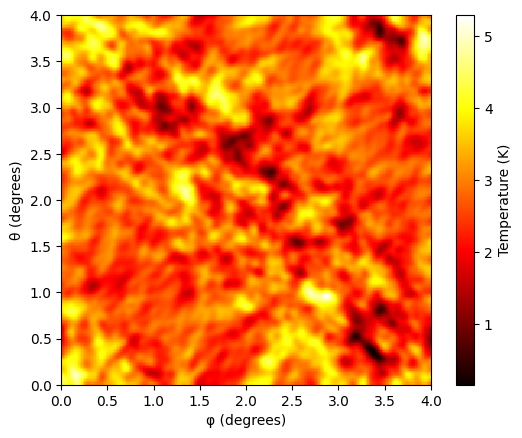

In [33]:
plt.imshow(cmb_map, extent=(0, side_length, 0, side_length), origin='lower',
                  cmap='hot', interpolation='nearest');
plt.colorbar(label='Temperature (K)')
plt.xlabel('φ (degrees)')
plt.ylabel('θ (degrees)')
plt.show()

In [43]:
m = 10**2
theta_00 = np.linspace(0.1, 5.7, m)
number_of_edges = np.zeros(theta_00.shape[0])
global_clustering = np.zeros(theta_00.shape[0])

In [45]:
np.random.seed(42)
for i in range(theta_00.shape[0]):
    cmb_map = generate_cmb_map(n, pixel_size, A, ell_0, alpha, fwhm)
    maxima = find_local_maxima(cmb_map)
    maxima_coords = convert_maxima_to_degree(maxima)
    G = construct_graph(maxima_coords, theta_00[i])
    global_clustering[i] = calculate_global_clustering(G)

In [146]:
np.random.seed(42)
theta_0 = 0.3
cmb_map = generate_cmb_map(n, pixel_size, A, ell_0, alpha, fwhm)
maxima = find_local_maxima(cmb_map)
maxima_coords = convert_maxima_to_degree(maxima)
G = construct_graph(maxima_coords, theta_0)
degree_values, counts = calculate_degree_distribution(G)

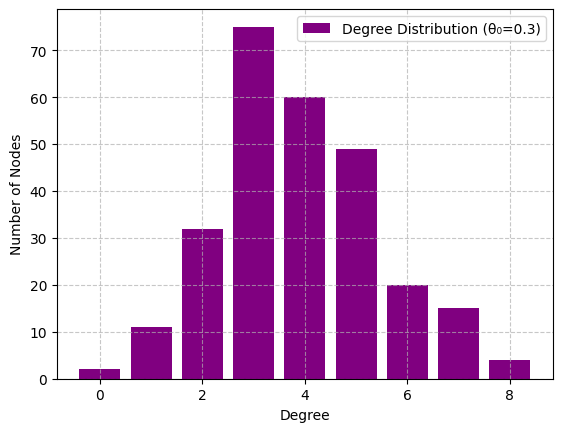

In [147]:
fig, ax = plt.subplots()
ax.bar(degree_values, counts, color='purple', alpha=1, label=f'Degree Distribution (θ₀={theta_0})')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('Degree')
ax.set_ylabel('Number of Nodes')
ax.legend()
plt.show()


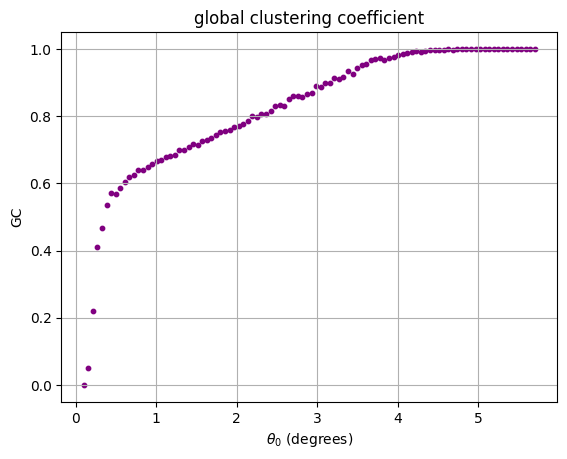

In [62]:
plt.scatter(theta_00, global_clustering, c='purple', label='global clustering', s=10)
plt.grid()
plt.ylabel('GC')
plt.xlabel('$θ_0$ (degrees)')
plt.title('global clustering coefficient')
plt.show()

In [152]:
ens = 3
path_length = np.zeros((ens, theta_00.shape[0]))
for i in range(ens):
    for j in range(theta_00.shape[0]):
        # ... existing code ...
        G = construct_graph(maxima_coords, theta_00[j])
        try:
            path_length[i, j] = nx.average_shortest_path_length(G)
        except nx.NetworkXError:  # If disconnected
            path_length[i, j] = np.nan
path_length_mean = np.nanmean(path_length, axis=0)

C:\Users\Mahyar\AppData\Local\Temp\ipykernel_6212\637536987.py:11: RuntimeWarning: Mean of empty slice
  path_length_mean = np.nanmean(path_length, axis=0)


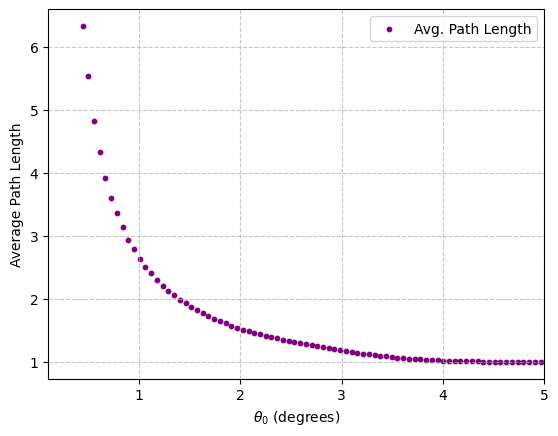

In [154]:
fig, ax = plt.subplots()
ax.scatter(theta_00, path_length_mean, s=10, c='purple', label='Avg. Path Length')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel(r'$\theta_0$ (degrees)')
ax.set_ylabel('Average Path Length')
ax.legend()
ax.set_xlim(1e-1, 5)
plt.savefig('path_length_plot.png', dpi=300, bbox_inches='tight')
plt.show()